#Tensorflow Object Detection using  Google Colab

Jupyter notebook providing steps to retrain a [ModelZoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) model with custom dataset.

It runs in [Google Colab](https://colab.research.google.com) using [Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection).

**Requirements are only dataset images and annotations file.**

The code is compatible with Object Detection api updates in July 13 2018 [release](https://github.com/tensorflow/models/tree/master/research/object_detection#july-13-2018).

**Colab Runtime type: Python2, GPU enabled.**



# Install required packages


In [0]:
%cd
  
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive

!pip install -q pycocotools

%cd ~/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim/'

!python object_detection/builders/model_builder_test.py


/root
/root/models/research

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

............s...
----------------------------------------------------------------------
Ran 16 tests in 0.070s

OK (skipped=1)


In [0]:
%cd ~/models/research/object_detection

/root/models/research/object_detection


# Download pretrained model

Cell downloads **faster_rcnn_inception_v2_coco** model to use as starting checkpoint.

To use another model from ModelZoo change MODEL var.

In [0]:
import os
import shutil
import glob
import urllib
import tarfile

MODEL = 'faster_rcnn_inception_v2_coco_2018_01_28'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = 'pretrained_model'

if not (os.path.exists(MODEL_FILE)):
  opener = urllib.URLopener()
  opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

#Upload jpg image for inference

In [0]:

from google.colab import files
from os import path

uploaded = files.upload()
  
for name, data in uploaded.items():
  with open('image1.jpg', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)

Saving image1.jpg to image1.jpg
saved file image1.jpg


In [0]:

from google.colab import files
from os import path

uploaded = files.upload()

Saving labelmap.pbtxt to labelmap.pbtxt


# Run inference


/root/models/research/object_detection


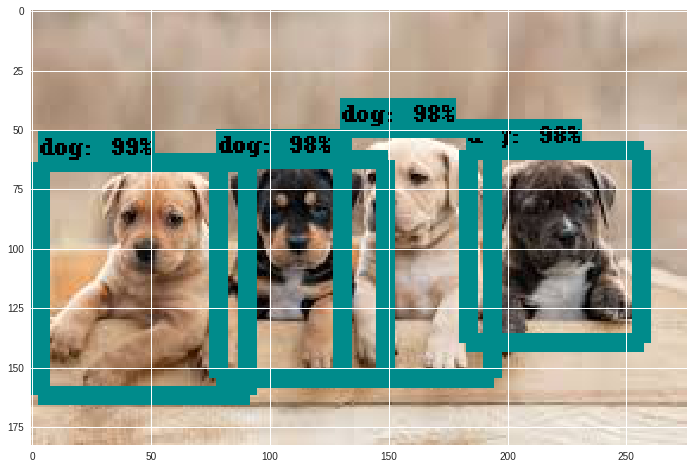

In [0]:
%cd ~/models/research/object_detection




import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


  
  
# This is needed to display the images.
%matplotlib inline




from utils import label_map_util

from utils import visualization_utils as vis_util




# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/root/models/research/object_detection/pretrained_model' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/root/models/research/object_detection', 'labelmap.pbtxt')

NUM_CLASSES = 91




detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
    
    
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)




def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)




# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/root/models/research/object_detection'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 2) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)




def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict




for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  